In [2]:
#Imprting libraries

import os
import pandas as pd
import keras 
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Input, Reshape, UpSampling2D
from tensorflow.keras.layers import  MaxPooling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Add, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns
import numpy as np
import time
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

LOCAL_DIR = '/Users/sakshamjain/Desktop/CItyscapes/'
GT_DIR = LOCAL_DIR + 'gtFine_trainvaltest/gtFine/'
IMG_DIR = LOCAL_DIR + 'leftImg8bit_trainvaltest/leftImg8bit/'   



In [ ]:
#here we are basically getting all the images from different sub folders named after cities and combining them in a single folder
for parent in listdir(GT_DIR):
    parent_dir = GT_DIR + parent
    if isdir(parent_dir):
        for child in listdir(parent_dir):
            if isdir(join(parent_dir, child)):
                keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
                keep = [f.split('/')[-1] for f in keep]
                for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                    move(join(parent_dir, child, filename), join(parent_dir, filename))
                rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR):
    parent_dir = IMG_DIR + parent
    if isdir(parent_dir):
        for child in listdir(parent_dir):
            if isdir(join(parent_dir, child)):
                for filename in listdir(join(parent_dir, child)):
                    move(join(parent_dir, child, filename), join(parent_dir, filename))
                rmtree(join(parent_dir, child))

In [ ]:
def prepare_tensor_dataset(images_path, masks_path):
    X_train, Y_train, X_val, Y_val = [], [], [], []

    # Define function to convert image filenames to mask filenames
    def image_to_mask_filename(image_filename):
        return image_filename.replace('_leftImg8bit.png', '_gtFine_color.png')

    # Process training data
    train_images = os.path.join(images_path, 'train')
    train_masks = os.path.join(masks_path, 'train')
    for img_file in tqdm(sorted(os.listdir(train_images))):
        img_path = os.path.join(train_images, img_file)
        mask_file = image_to_mask_filename(img_file)
        mask_path = os.path.join(train_masks, mask_file)
        img, mask = preprocess(img_path, mask_path)
        X_train.append(img)
        Y_train.append(mask)

    # Process validation data
    val_images = os.path.join(images_path, 'val')
    val_masks = os.path.join(masks_path, 'val')
    for img_file in tqdm(sorted(os.listdir(val_images))):
        img_path = os.path.join(val_images, img_file)
        mask_file = image_to_mask_filename(img_file)
        mask_path = os.path.join(val_masks, mask_file)
        img, mask = preprocess(img_path, mask_path)
        X_val.append(img)
        Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val

In [ ]:
images_path="/Users/sakshamjain/Desktop/CItyscapes/leftImg8bit_trainvaltest/leftImg8bit/"
masks_path="/Users/sakshamjain/Desktop/CItyscapes/gtFine_trainvaltest/gtFine/"

In [ ]:
X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset(images_path, masks_path)

In [ ]:
X_train_128 = np.array(X_train)
Y_train_128 = np.array(Y_train)
X_valid_128 = np.array(X_valid)
Y_valid_128= np.array(Y_valid)

In [3]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 8

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

In [4]:
num_classes = len(id_map.keys())
print(num_classes)


31


In [5]:
from PIL import Image
import numpy as np
import os

def preprocess(normalpath,img2path):
    img1=Image.open(normalpath)
    img1 = img1.resize((128, 128))
    img2=Image.open(img2path)
    img2 = img2.convert('RGB')

    img2 = img2.resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))  
    del img2
    return img1,mask


In [9]:
X_train_128=np.load("/Users/sakshamjain/Desktop/CItyscapes/X_train_128.npy")
Y_train_128=np.load("/Users/sakshamjain/Desktop/CItyscapes/_train_128.npy")
X_valid_128=np.load("/Users/sakshamjain/Desktop/CItyscapes/X_train_128.npy")
Y_valid_128=np.load("/Users/sakshamjain/Desktop/CItyscapes/X_train_128.npy")

In [25]:
print(Y_valid_128.shape)

(500, 128, 128, 1)


In [10]:
def residual(inputs, filters, index, strides, padding = 'same'):
    res_conv = Conv2D(filters = filters, 
                      kernel_size = 3, 
                      strides = strides,
                      padding = padding,
                      name = f'residual_conv_{index}')(inputs)
    res_conv = BatchNormalization(name = f'residual_BN_{index}')(res_conv)
    
    return res_conv

In [11]:
def sep_bn_act(inputs, filters, index, use_maxpool):
    block = Activation('relu')(inputs)
    block = SeparableConv2D(filters = filters, 
                            kernel_size = 3, 
                            padding ='same', 
                            name = f'block{index}_sepconv_1', )(block)
    block = BatchNormalization(name = f'block{index}_sepconv1_BN')(block)
    block = Activation('relu', name = f'block{index}_sepconv1_act')(block)
    
    block = SeparableConv2D(filters = filters, 
                            kernel_size = 3, 
                            padding ='same', 
                            name = f'block{index}_sepconv_2')(block)
    
    block = BatchNormalization(name = f'block{index}_sepconv2_BN')(block)
    
#     if use_maxpool:
#         block = MaxPooling2D(pool_size = 2)(block)
#     else:
    block = Activation('relu')(block)
        
        
    return block

In [12]:
def light_xception(inputs, mode = 'layers'):

    '''
    this function create like-xception model
    with 5 millions params instead 22 millons 
    in original

    Arguments:
        inputs(tensor): outputs of previuos layers or input data
        mode(str): parameter of this model
    
    Returns: 
        light-weight xception model
    '''
    strides = 1
    image_height = inputs.shape[1]
    image_width = inputs.shape[2] 
    width_condition = np.sqrt(image_width) == int(np.sqrt(image_width))
    height_condition = np.sqrt(image_height) == int(np.sqrt(image_height))
    assertion = 'both sides of image must be 2 **n and greater than 2 **3'
    # assert width_condition, assertion
    # assert height_condition, assertion
    
    index = 1
    
    #       input block           
    ################################################################
    if mode == 'model':
        inputs = Input(shape = input_shape, name = 'input_layer')
    
    # block 1
    ################################################################
    filters = 64
    block_0 = sep_bn_act(inputs = inputs, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = False)
    
    ################################################################
    
    index +=1
    filters = 128
    
    #separable
    block_1 = sep_bn_act(inputs = block_0, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = True)
    
    #    residual block      
    res_conv_1 = residual(inputs = block_0, 
                          filters = filters,
                          index=index, 
                          strides = strides)
    
    #    add block    
    add_1 = Add(name = f'add_{index}')([block_1, res_conv_1])
    
    
    #################################################################
    
    index +=1
    filters = 256
    
    #separable
    block_2 = sep_bn_act(inputs = add_1, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = True)
    
    #    residual block      
    res_conv_2 = residual(inputs = add_1, 
                          filters = filters, 
                          index=index, 
                          strides = strides)
    #    add block    
    add_2 = Add(name = f'add_{index}')([block_2, res_conv_2])
    
    #################################################################
    
    index +=1
    filters = 512
    
    #separable
    block_3 = sep_bn_act(inputs = add_1, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = True)
    
    #    residual block      
    res_conv_3 = residual(inputs = add_1,
                          filters = filters, 
                          index=index, 
                          strides = strides)
    #    add block    
    add_3 = Add(name = f'add_{index}')([block_3, res_conv_3])
    
    #################################################################
    
    index +=1
    filters = 512
    
    #separable
    block_4 = sep_bn_act(inputs = add_3, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = False)
    index +=1
    block_4 = sep_bn_act(inputs = block_4, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = False)
    
    #    add block    
    add_4 = Add(name = f'add_{index}')([block_4, add_3])
    index +=1
    filters = 512
    
    #separable
    block_5 = sep_bn_act(inputs = add_4, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = True)
    #    residual block      
    res_conv_5 = residual(inputs = add_4, 
                          filters = filters, 
                          index=index, 
                          strides = strides)
    #    add block    
    add_5 = Add(name = f'add_{index}')([block_5, res_conv_5])
    
    ##################################################################
    
    index +=1
    filters = 128
    
    #separable
    outputs = sep_bn_act(inputs = add_5, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = False)
    
    result = Model(inputs = inputs, outputs = outputs)
    
    if mode == 'layers':
        result = outputs
    
    return result

input_shape = (128, 128, 3)


In [13]:
def PPM(inputs):
    '''
    PPM - Pyramyd Pooling Module
    this function just create PP module
    '''
    
    # parameters
    filters = 128
    kernel_size = (1, 1)
    interpolation = 'bilinear'
    
    #base
    base = light_xception(inputs = inputs, mode = 'layers')
    
    #red
    red = GlobalAveragePooling2D(name = 'red_glob_av_pooling')(base)
    red = Reshape(target_shape = (1, 1,128))(red)
    red = Conv2D(filters = filters, 
                 kernel_size = kernel_size, 
                 padding = 'same', name = 'red_1_1x1')(red)
    red = BatchNormalization(name = 'red_BN_1')(red)
    red = Conv2D(filters = filters * 2,
                 kernel_size = kernel_size, 
                 padding = 'same', name = 'red_2_1x1')(red)
    red = BatchNormalization(name = 'red_BN_2')(red)
    red = Conv2D(filters = filters, 
                 kernel_size = kernel_size, 
                 padding = 'same', name = 'red_3_1x1')(red)
    red = BatchNormalization(name = 'red_BN_3')(red)
    red = UpSampling2D(size = 128, 
                       interpolation = interpolation, 
                       name = 'red_upsampling')(red)
    
    #blue
    blue = AveragePooling2D(pool_size = 2, 
                            name = 'blue_av_pooling')(base)
    blue = Conv2D(filters = filters, 
                  kernel_size = kernel_size, 
                  padding = 'same', 
                  name = 'blue_1_1x1')(blue)
    blue = BatchNormalization(name = 'blue_BN_1')(blue)
    blue = Conv2D(filters = filters * 2, 
                  kernel_size = kernel_size, 
                  padding = 'same', name = 'blue_2_1x1')(blue)
    blue = BatchNormalization(name = 'blue_BN_2')(blue)
    blue = Conv2D(filters = filters, 
                  kernel_size = kernel_size, 
                  padding = 'same', name = 'blue_3_1x1')(blue)
    blue = BatchNormalization(name = 'blue_BN_3')(blue)
    blue = UpSampling2D(size = 2, interpolation = interpolation, 
                        name = 'blue_upsampling')(blue)
    
    #green
    green = AveragePooling2D(pool_size = 4, 
                             name = 'green_av_pooliing')(base)
    green = Conv2D(filters = filters, 
                   kernel_size = kernel_size, 
                   padding = 'same', name = 'green_1_1x1')(green)
    green = BatchNormalization(name = 'green_BN_1')(green)
    green = Conv2D(filters = filters * 2, 
                   kernel_size = 
                   kernel_size, padding = 'same', 
                   name = 'green_2_1x1')(green)
    green = BatchNormalization(name = 'green_BN_2')(green)
    green = Conv2D(filters = filters, 
                   kernel_size = kernel_size, 
                   padding = 'same', name = 'green_3_1x1')(green)
    green = BatchNormalization(name = 'green_BN_3')(green)
    green = UpSampling2D(size = 4, name = 'green_upsampling')(green)
    
    #yellow
    yellow = AveragePooling2D(pool_size = 8, 
                              name = 'yellow_av_pooling')(base)
    yellow = Conv2D(filters = filters, 
                    kernel_size = kernel_size, padding = 'same', 
                    name = 'yellow_1_1x1')(yellow)
    yellow = BatchNormalization(name = 'yellow_BN_1')(yellow)
    yellow = Conv2D(filters = filters * 2, 
                    kernel_size = kernel_size, 
                    padding = 'same', name = 'yellow_2_1x1')(yellow)
    yellow = BatchNormalization(name = 'yellow_BN_2')(yellow)
    yellow = Conv2D(filters = filters, 
                    kernel_size = kernel_size, 
                    padding = 'same', name = 'yellow_3_1x1')(yellow)
    yellow = BatchNormalization(name = 'yellow_BN_3')(yellow)
    yellow = UpSampling2D(size = 8, name = 'yellow_upsampling')(yellow)
    
    result = Concatenate(
        name = 'concatenate_layer')([base, red, blue, green, yellow])
    
    return result
    

In [14]:
def PSPnet_last_conv(inputs, classes):
    ppm_outputs = PPM(inputs)
    
    x = Conv2D(filters = classes, 
               kernel_size = 3, 
               padding = 'same', 
               name = 'last_module_conv')(ppm_outputs)
    x = BatchNormalization(name = 'last_module_BN')(x)
    x = Activation('softmax')(x)
    
    return x





In [15]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, normalpath, img2path, model, **kwargs):
        super().__init__(**kwargs)
        self.normalpath = normalpath
        self.img2path = img2path
        self._model = model  # Ensure the model is passed as a parameter

    def on_epoch_end(self, epoch, logs=None):
        img, mask = preprocess(self.normalpath, self.img2path)  # Updated to use two paths
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))  # Assuming img1 is a color image
        pred = self.model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].imshow(mask.squeeze(), cmap='plasma')  # Use squeeze to remove single-channel dimension
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred, cmap='plasma')
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")
  
  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

In [16]:
def build_PSPnet():
    inputs = Input(shape = input_shape, name = 'input')
    outputs = PSPnet_last_conv(inputs, classes = 31)

    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.metrics import MeanIoU

    pspnet = Model(inputs = inputs, outputs = outputs, name = 'PSPnet')
    pspnet.compile(loss = "sparse_categorical_crossentropy",
               optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])
    return pspnet

pspnet = build_PSPnet()

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 12, restore_best_weights = True)
callback = VizCallback(normalpath="/kaggle/input/cityyy/frankfurt_000000_000576_leftImg8bit.png", img2path="/kaggle/input/cityyy/frankfurt_000000_000576_gtFine_color.png", model=pspnet)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'gaandmaardenge.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)


In [23]:
pspnet.summary()

Model: "PSPnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ input[0][0]       │
│ (Activation)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_sepconv_1    │ (None, 128, 128,  │        283 │ activation[0][0]  │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_sepconv1_BN  │ (None, 128, 128,  │        256 │ block1_sepconv_1… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_sepconv1_act │ (None, 128, 128,  │          0 │ block1_sepconv1_… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_sepconv_2    │ (None, 128, 128,  │      4,736 │ block1_sepconv1_… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_sepconv2_BN  │ (None, 128, 128,  │        256 │ block1_sepconv_2… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ block1_sepconv2_… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv_1    │ (None, 128, 128,  │      8,896 │ activation_2[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_BN  │ (None, 128, 128,  │        512 │ block2_sepconv_1… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_act │ (None, 128, 128,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv_2    │ (None, 128, 128,  │     17,664 │ block2_sepconv1_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_BN  │ (None, 128, 128,  │        512 │ block2_sepconv_2… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_conv_2     │ (None, 128, 128,  │     73,856 │ activation_1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ block2_sepconv2_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_BN_2       │ (None, 128, 128,  │        512 │ residual_conv_2[

 Total params: 16,833,384 (64.21 MB)

 Trainable params: 5,605,816 (21.38 MB)

 Non-trainable params: 15,934 (62.24 KB)

 Optimizer params: 11,211,634 (42.77 MB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.8579 - loss: 0.5160 - mean_iou: 0.341


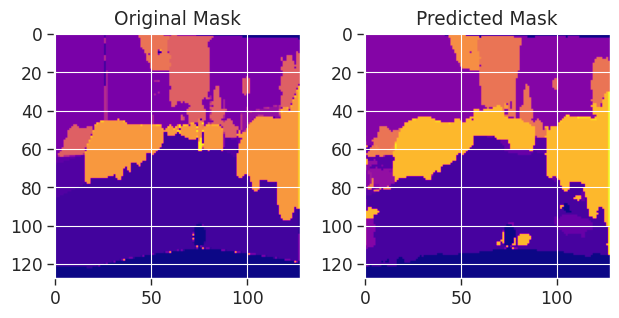


Epoch 1: val_loss improved from inf to 0.78678, saving model to gaandmaardenge.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 251s 674ms/step - accuracy: 0.8579 - loss: 0.5161 - mean_iou: 0.3411 - val_accuracy: 0.7906 - val_loss: 0.7868 - val_mean_iou: 0.2618
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.8595 - loss: 0.5024 - mean_iou: 0.348


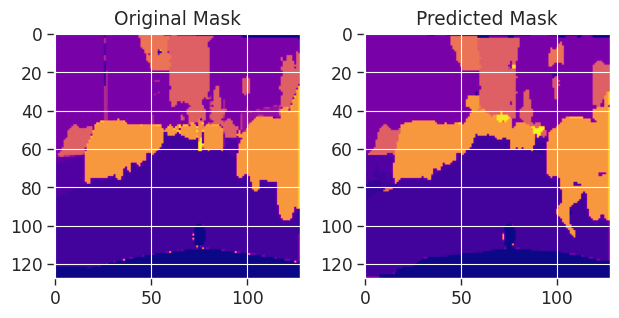


Epoch 2: val_loss improved from 0.78678 to 0.77767, saving model to gaandmaardenge.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 251s 675ms/step - accuracy: 0.8596 - loss: 0.5024 - mean_iou: 0.3480 - val_accuracy: 0.7900 - val_loss: 0.7777 - val_mean_iou: 0.2670
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.8651 - loss: 0.4786 - mean_iou: 0.363


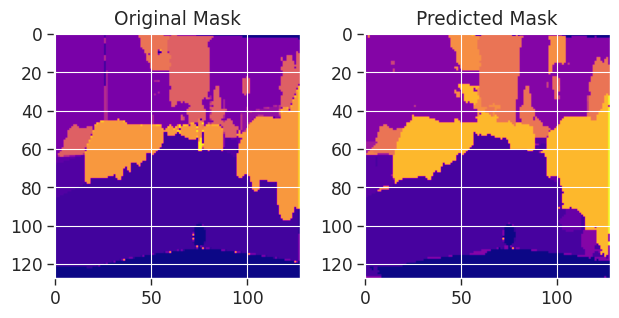


Epoch 3: val_loss improved from 0.77767 to 0.71105, saving model to gaandmaardenge.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 251s 675ms/step - accuracy: 0.8651 - loss: 0.4786 - mean_iou: 0.3631 - val_accuracy: 0.8102 - val_loss: 0.7111 - val_mean_iou: 0.2675
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.8714 - loss: 0.4533 - mean_iou: 0.377


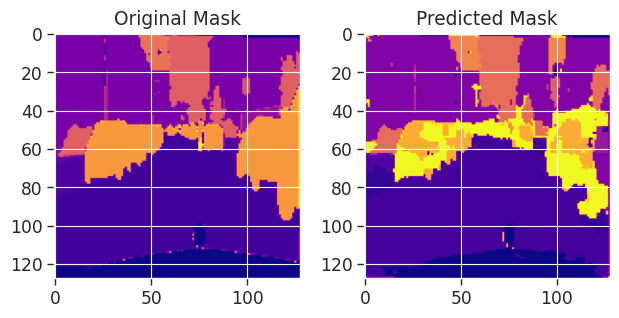


Epoch 4: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.8714 - loss: 0.4533 - mean_iou: 0.3771 - val_accuracy: 0.6792 - val_loss: 1.1406 - val_mean_iou: 0.2118
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.8731 - loss: 0.4437 - mean_iou: 0.387


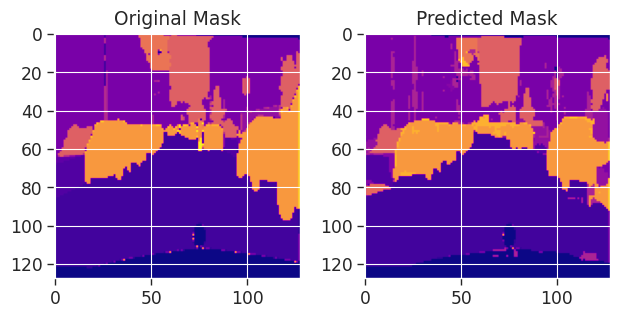


Epoch 5: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.8731 - loss: 0.4437 - mean_iou: 0.3872 - val_accuracy: 0.7804 - val_loss: 0.7838 - val_mean_iou: 0.2836
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.8792 - loss: 0.4215 - mean_iou: 0.405


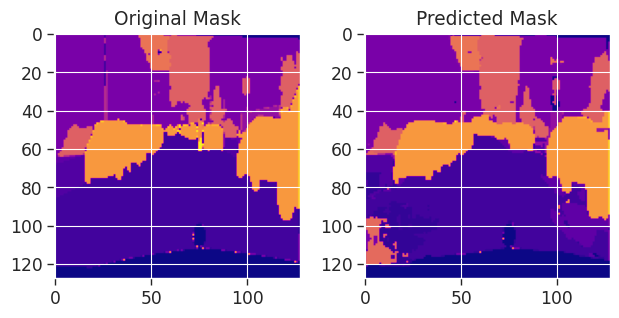


Epoch 6: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.8792 - loss: 0.4216 - mean_iou: 0.4057 - val_accuracy: 0.7482 - val_loss: 0.8702 - val_mean_iou: 0.2835
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.8825 - loss: 0.4089 - mean_iou: 0.414


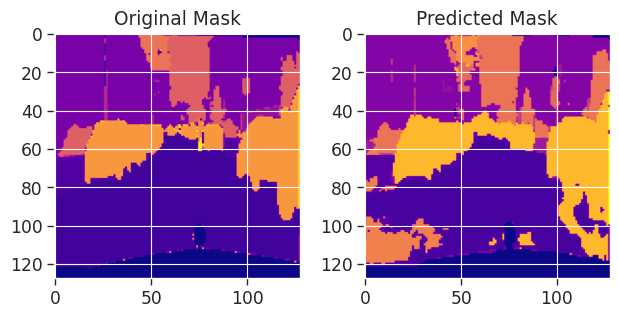


Epoch 7: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.8825 - loss: 0.4089 - mean_iou: 0.4146 - val_accuracy: 0.7816 - val_loss: 0.7778 - val_mean_iou: 0.2638
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.8864 - loss: 0.3928 - mean_iou: 0.430


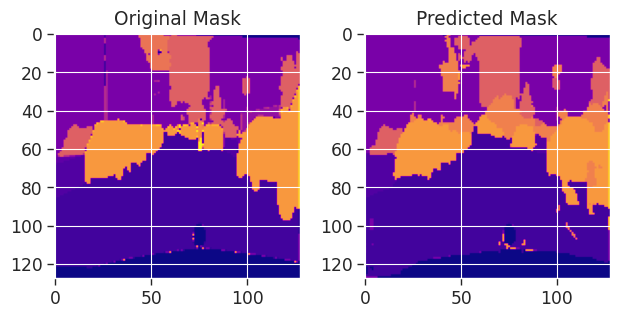


Epoch 8: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.8864 - loss: 0.3928 - mean_iou: 0.4309 - val_accuracy: 0.7597 - val_loss: 0.9589 - val_mean_iou: 0.2320
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.8910 - loss: 0.3780 - mean_iou: 0.443


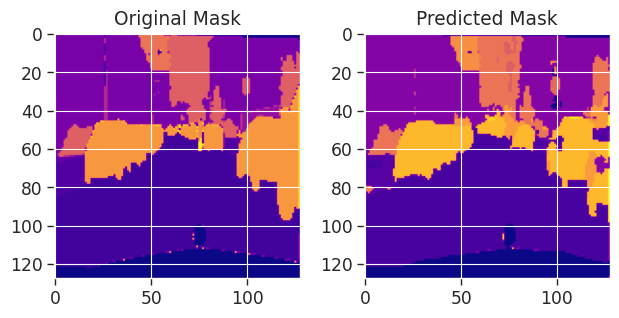


Epoch 9: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.8910 - loss: 0.3780 - mean_iou: 0.4437 - val_accuracy: 0.7999 - val_loss: 0.7250 - val_mean_iou: 0.2862
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.8941 - loss: 0.3671 - mean_iou: 0.454


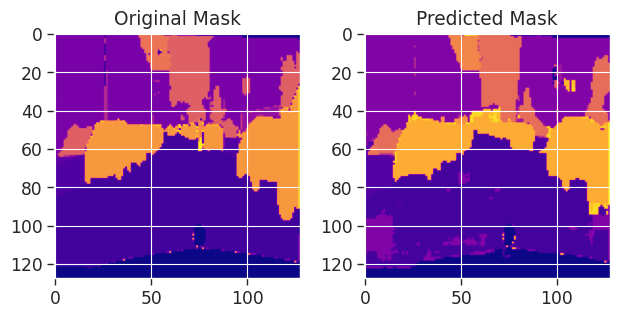


Epoch 10: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 672ms/step - accuracy: 0.8941 - loss: 0.3671 - mean_iou: 0.4543 - val_accuracy: 0.8028 - val_loss: 0.7633 - val_mean_iou: 0.2701
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.8979 - loss: 0.3526 - mean_iou: 0.470


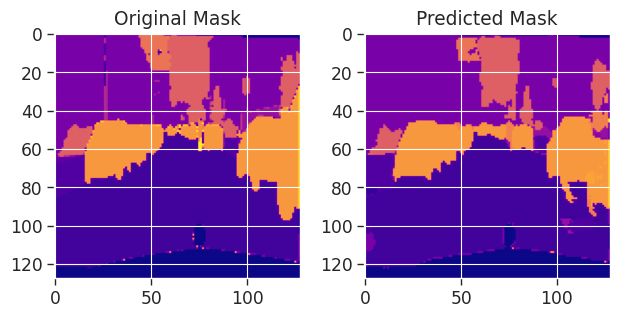


Epoch 11: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.8979 - loss: 0.3526 - mean_iou: 0.4709 - val_accuracy: 0.7978 - val_loss: 0.7652 - val_mean_iou: 0.2783
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.9019 - loss: 0.3401 - mean_iou: 0.486


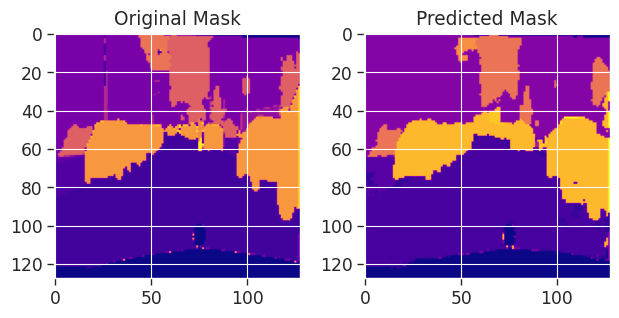


Epoch 12: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9019 - loss: 0.3401 - mean_iou: 0.4865 - val_accuracy: 0.7421 - val_loss: 0.9630 - val_mean_iou: 0.2666
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step/step - accuracy: 0.9043 - loss: 0.3302 - mean_iou: 0.501


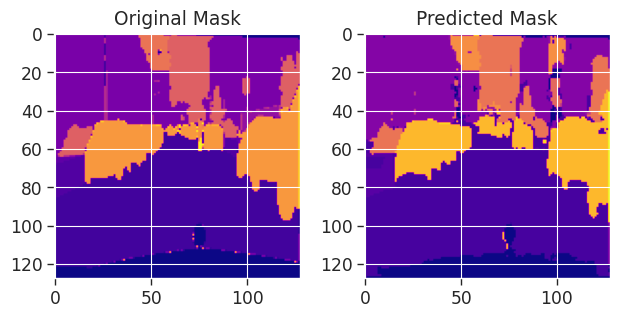


Epoch 13: val_loss did not improve from 0.71105
372/372 ━━━━━━━━━━━━━━━━━━━━ 251s 674ms/step - accuracy: 0.9043 - loss: 0.3302 - mean_iou: 0.5012 - val_accuracy: 0.7755 - val_loss: 0.9115 - val_mean_iou: 0.2596
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.9054 - loss: 0.3250 - mean_iou: 0.502


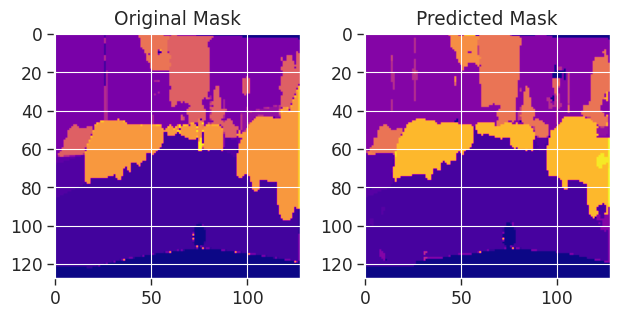


Epoch 14: val_loss improved from 0.71105 to 0.68007, saving model to gaandmaardenge.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 251s 675ms/step - accuracy: 0.9054 - loss: 0.3250 - mean_iou: 0.5023 - val_accuracy: 0.8284 - val_loss: 0.6801 - val_mean_iou: 0.2941
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.9116 - loss: 0.3042 - mean_iou: 0.525


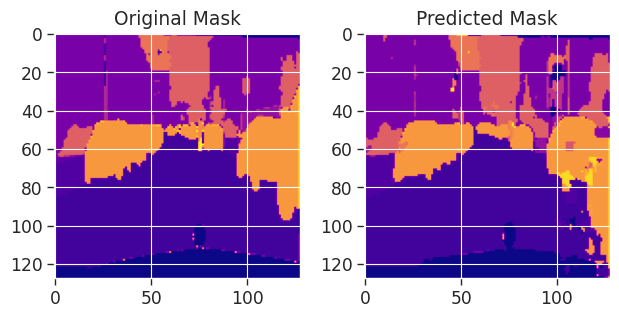


Epoch 15: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9116 - loss: 0.3042 - mean_iou: 0.5258 - val_accuracy: 0.7402 - val_loss: 0.9628 - val_mean_iou: 0.2665
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.9112 - loss: 0.3045 - mean_iou: 0.530


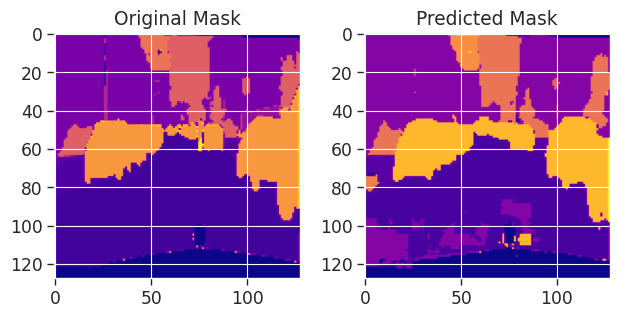


Epoch 16: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9112 - loss: 0.3045 - mean_iou: 0.5308 - val_accuracy: 0.8228 - val_loss: 0.7107 - val_mean_iou: 0.2784
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.9152 - loss: 0.2906 - mean_iou: 0.542


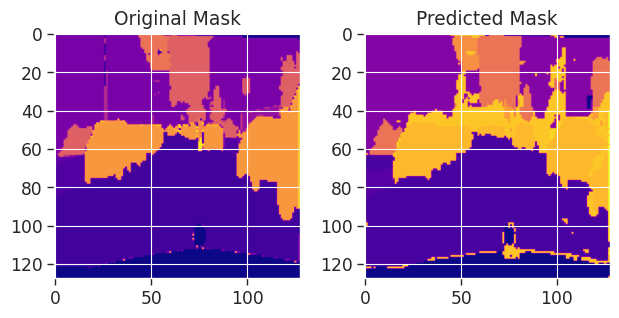


Epoch 17: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9152 - loss: 0.2907 - mean_iou: 0.5424 - val_accuracy: 0.6998 - val_loss: 1.2764 - val_mean_iou: 0.2358
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step/step - accuracy: 0.9141 - loss: 0.2924 - mean_iou: 0.545


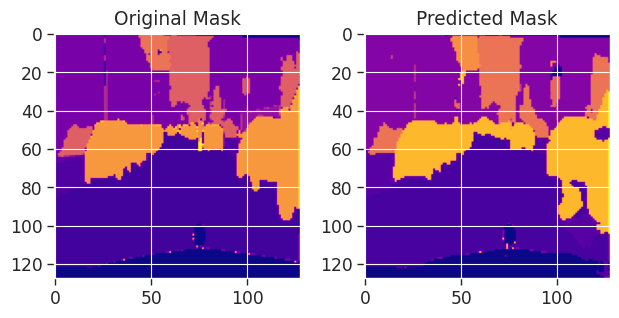


Epoch 18: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9141 - loss: 0.2924 - mean_iou: 0.5455 - val_accuracy: 0.8213 - val_loss: 0.7558 - val_mean_iou: 0.2906
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.9175 - loss: 0.2810 - mean_iou: 0.565


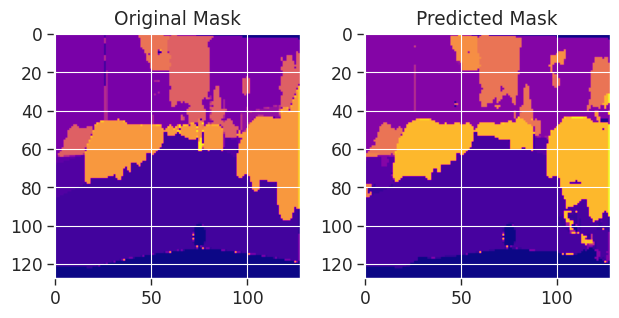


Epoch 19: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 262s 673ms/step - accuracy: 0.9175 - loss: 0.2810 - mean_iou: 0.5650 - val_accuracy: 0.8040 - val_loss: 0.7155 - val_mean_iou: 0.3077
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.9222 - loss: 0.2655 - mean_iou: 0.572


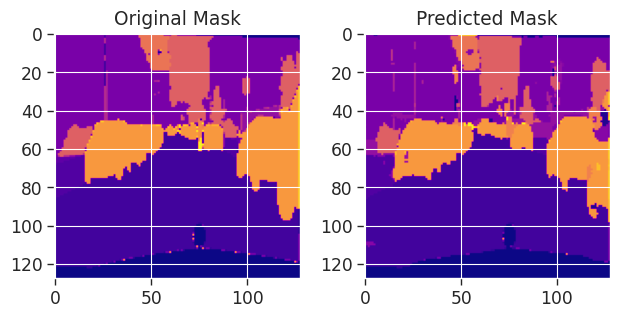


Epoch 20: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9222 - loss: 0.2655 - mean_iou: 0.5721 - val_accuracy: 0.8025 - val_loss: 0.7383 - val_mean_iou: 0.2956
Epoch 21/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.9246 - loss: 0.2570 - mean_iou: 0.590


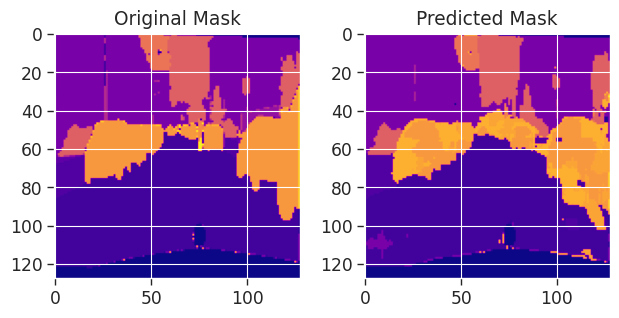


Epoch 21: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9246 - loss: 0.2570 - mean_iou: 0.5907 - val_accuracy: 0.7917 - val_loss: 0.8219 - val_mean_iou: 0.2811
Epoch 22/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.9274 - loss: 0.2468 - mean_iou: 0.598


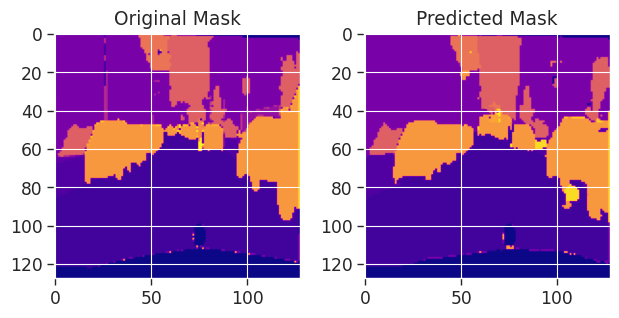


Epoch 22: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 251s 673ms/step - accuracy: 0.9274 - loss: 0.2468 - mean_iou: 0.5986 - val_accuracy: 0.8074 - val_loss: 0.7938 - val_mean_iou: 0.2933
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.9286 - loss: 0.2425 - mean_iou: 0.609


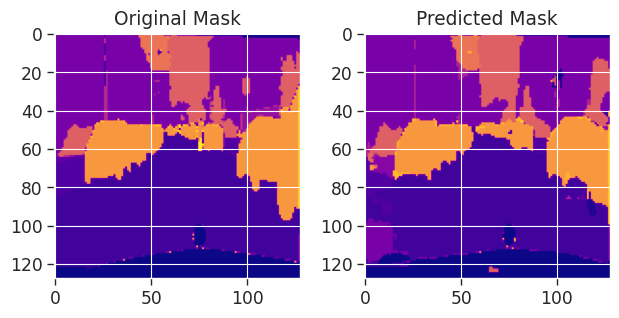


Epoch 23: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9286 - loss: 0.2425 - mean_iou: 0.6091 - val_accuracy: 0.7985 - val_loss: 0.7966 - val_mean_iou: 0.2971
Epoch 24/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.9248 - loss: 0.2533 - mean_iou: 0.586


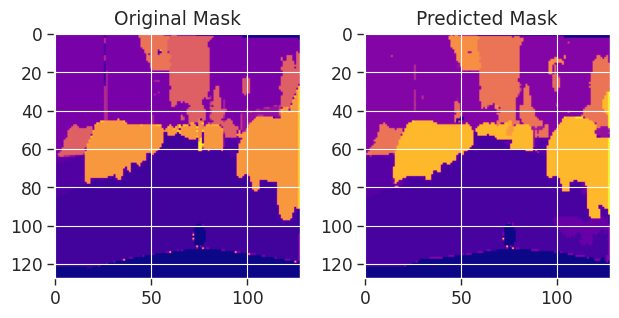


Epoch 24: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9248 - loss: 0.2533 - mean_iou: 0.5863 - val_accuracy: 0.8254 - val_loss: 0.6852 - val_mean_iou: 0.3151
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/step - accuracy: 0.9292 - loss: 0.2385 - mean_iou: 0.609


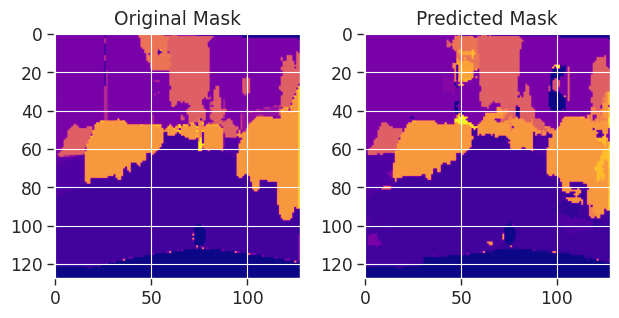


Epoch 25: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9292 - loss: 0.2386 - mean_iou: 0.6092 - val_accuracy: 0.7816 - val_loss: 0.8749 - val_mean_iou: 0.2666
Epoch 26/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step/step - accuracy: 0.9270 - loss: 0.2459 - mean_iou: 0.596


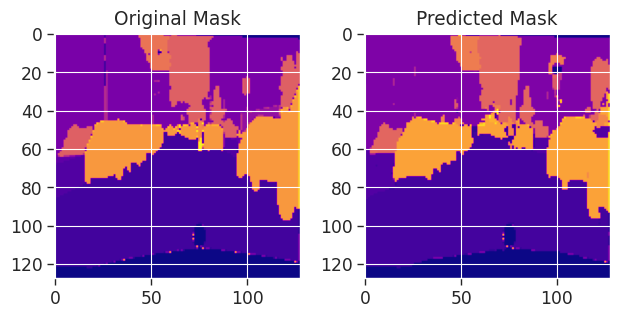


Epoch 26: val_loss did not improve from 0.68007
372/372 ━━━━━━━━━━━━━━━━━━━━ 250s 673ms/step - accuracy: 0.9270 - loss: 0.2459 - mean_iou: 0.5967 - val_accuracy: 0.7927 - val_loss: 0.7763 - val_mean_iou: 0.3004


In [24]:
history = pspnet.fit(x=X_train_128, y=Y_train_128, epochs = 100, batch_size = BATCH_SIZE, validation_data = (X_valid_128, Y_valid_128), callbacks=[early_stopping, callback,model_checkpoint])

In [21]:
pspnet.save("op.h5")